Intensity vs Fermi Chopper frequency -- Chopper 2

Just try the original parameters

In [3]:
cd ~/dv/sns-chops/resolution/ARCS/PyChop/

/SNS/users/lj7/dv/sns-chops/resolution/ARCS/PyChop


In [4]:
import numpy as np, os, sys, glob
from matplotlib import pyplot as plt

In [5]:
from mcni.utils import conversion as C

In [6]:
%matplotlib notebook

# Exp data

In [7]:
import Vdata2018
reload(Vdata2018)

<module 'Vdata2018' from 'Vdata2018.pyc'>

In [8]:
# expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC1_2018.dat'))
expdata = Vdata2018.ExpData(os.path.join(Vdata2018.datadir, './V_Cali_Int_Res_FC2_2018_v2.dat'))

reading data. please wait...
  done


In [9]:
monitor_int_data = np.loadtxt('../V_Cali_MonitorInt_FC2_2018_v2.dat')
runno2monitorint = dict()
runno2vscattint = dict()
for runno, mint, vscatt, duration in monitor_int_data:
    runno2monitorint[int(runno)] = mint/duration
    runno2vscattint[int(runno)] = vscatt/duration

In [10]:
t_runno, t_mint, t_vscatt, t_duration = monitor_int_data.T

In [11]:
# t_runno

In [12]:
runno2vscattint[108045]

8623.7975985790017

In [13]:
runno2vscattint[108064]

4449.9171607955823

In [14]:
unique_nominal_Eis = set( list(expdata.Ei_list)) 

In [15]:
# unique_nominal_Eis

# Load mcvine sims

In [16]:
mcvine_table = np.loadtxt('../mcvine-FWHM-counts.dat')

In [17]:
mcvine_Eis, mcvine_freqs, mcvine_FWHMs, mcvine_counts = mcvine_table.T

In [18]:
Ei = 100.

In [19]:
condition = np.isclose(expdata.vdata.Energy, Ei)

In [20]:
expdata.vdata.RunNumber[condition]

13     108045.0
28     108064.0
61     108101.0
74     108114.0
96     108138.0
109    108151.0
127    108169.0
142    108184.0
172    108007.0
181    108026.0
Name: RunNumber, dtype: float64

In [21]:
expdata.chopper_freqs[condition]

array([ 180.,  240.,  300.,  360.,  420.,  480.,  540.,  600.,   60.,  120.])

In [22]:
mint = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]])

PyChop

In [23]:
sys.path.insert(0, "/SNS/users/lj7/dv")

In [24]:
from PyChop import PyChop2

In [25]:
instrument = PyChop2('arcs-opt.yaml', 'ARCS-100-1.5-SMI', 600)

In [26]:
instrument.getResFlux(Etrans=0, Ei_in=100., frequency=600)

(array([ 4.11798862]), array([ 45.88395835]))

In [27]:
def flux_res_list_pychop(
    fc_freq_list,
    E=0,
    aperture_width=0.1751, S1=281., S2=79., B1=0.087, B2=0.4, Emod=172., 
    Ei = 100.,
    fc_pslit = 1.5, fc_pslat = 0.41, fc_radius=50., fc_rho = 580.,
    fc_choice='ARCS-100-1.5-SMI'):
    
    template = open('./arcs-opt-template.yaml').read()
    content = template.format(aperture_width=aperture_width)
    optyaml = 'arcs-opt.yaml'
    with open(optyaml, 'wt') as of:
        of.write(content)
    instrument = PyChop2(optyaml, fc_choice)
    instrument.ei = Ei
    instrument.moderator.mod_pars = [S1, S2, B1, B2, Emod]
    # print instrument.moderator.mod_pars
    # Fermi chopper
    fc = instrument.chopper_system.packages[fc_choice]
    fc.pslit = fc_pslit
    fc.pslat = fc_pslat
    fc.radius = fc_radius
    fc.rho = fc_rho
    # 
    ret = []
    for freq in fc_freq_list:
        res, flux = instrument.getResFlux(Etrans=E, Ei_in=Ei, frequency=freq)
        res = res[0]; flux = flux[0]
        ret.append( (flux*res, res) )
    return np.array(ret)

In [28]:
v_1p8AA = C.k2v(2*np.pi/1.8)

In [29]:
def getExpXY(Ei):
    "return freq, monitor intensity, V scatt intensity, FWHM"
    condition = np.isclose(expdata.vdata.Energy, Ei)
    x = expdata.chopper_freqs[condition]
    y1 = np.array([runno2monitorint[rn] for rn in expdata.vdata.RunNumber[condition]]) *C.e2v(Ei)/v_1p8AA
    # y2 = expdata.intensity[condition]*scale_vscatt2mcvine  # this is integrated S(E) intensity
    y2 = np.array([runno2vscattint[rn] for rn in expdata.vdata.RunNumber[condition]])
    y3 = expdata.FWHM[condition]
    return np.array(sorted(zip(x,y1,y2,y3))).T

In [30]:
def getMcvineXY(Ei):
    "return freq, counts, FWHM"
    mcvine_conditions = np.isclose(mcvine_Eis, Ei)
    freqs = mcvine_freqs[mcvine_conditions]
    counts = mcvine_counts[mcvine_conditions]
    FWHMs = mcvine_FWHMs[mcvine_conditions]
    return freqs, counts, FWHMs

In [31]:
flux_scale = 3.6e3

In [32]:
len(unique_nominal_Eis)

22

In [33]:
Ei_list = sorted(unique_nominal_Eis)
datatable = dict()
import warnings
for Ei in Ei_list:
    freqs, monInt, vscattInt, expFWHM = getExpXY(Ei)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model_flux, model_res = flux_res_list_pychop(freqs, Ei=Ei, fc_rho=640.).T
    mcv_freqs, mcv_Int, mcv_FWHM = getMcvineXY(Ei)
    datatable[Ei] = freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM

In [34]:
mcvine_scale = 1./25 * 1.4/2.
pychop_scale = 1e-3 * 1e6 /25 * 1.4/2
mon_scale = 1e5 / 25 /60.
# mon_scale *= 2  # fudge factor
vscatt_scale = 2.5e4

mcvine_scale/=2
pychop_scale/=2
vscatt_scale/=2

In [35]:
model_flux.shape

(2,)

In [36]:
pulse_to_second_MW_scale = 60./1.4

<IPython.core.display.Javascript object>


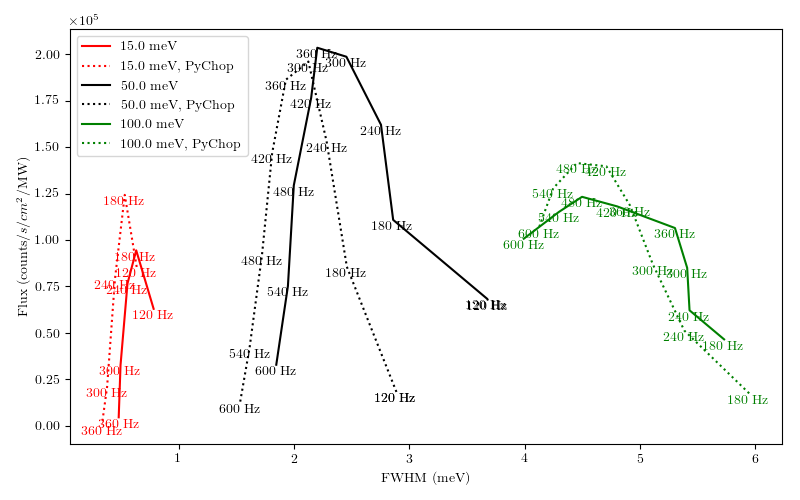

In [43]:
Eilist = sorted(unique_nominal_Eis)[3:15:5]
# print Eilist
N = len(Eilist)
plt.figure(figsize=(8,5))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

colors = ['r', 'k', 'g']

for i, Ei in enumerate(Eilist):
    color = colors[i]
    freqs, monInt, vscattInt, expFWHM, model_flux, model_res, mcv_freqs, mcv_Int, mcv_FWHM = datatable[Ei]
    fwhm_median = np.median(expFWHM)
    fwhm_sigma = np.std(expFWHM)
    good = np.logical_and(
        expFWHM<min(expFWHM.min()*2, fwhm_median+fwhm_sigma*1),
        expFWHM>fwhm_median-fwhm_sigma*3)
    xs,ys = expFWHM[good], monInt[good]*mon_scale*pulse_to_second_MW_scale
    plt.plot(xs, ys, color+'-', label='%s meV' % Ei)
    labels = ['%d Hz' % freq for freq in freqs[good]]
    for label, x, y in zip(labels, xs, ys):
        plt.annotate(
            label,
            xy=(x, y), xytext=(15, -10),
            textcoords='offset points', ha='right', va='bottom',
            color=color,
            # bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            # arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )
    
    xs, ys = model_res[good], (model_flux*pychop_scale*pulse_to_second_MW_scale)[good]
    plt.plot(xs, ys, color+':', label='%s meV, PyChop' % Ei)
    for label, x, y in zip(labels, xs, ys):
        plt.annotate(
            label,
            xy=(x, y), xytext=(15, -10),
            textcoords='offset points', ha='right', va='bottom',
            color=color,
            # bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            # arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        )
    continue

plt.xlabel("FWHM (meV)")
plt.ylabel("Flux (counts/$s/cm^2$/MW)")

plt.legend(loc='upper left')
plt.tight_layout()